In [1]:
# === Housekeeping ===

# Imports
import os
import sys
import warnings
import numpy as np
import pandas as pd
import powerlaw
import scipy.optimize as opt
import matplotlib.pyplot as plt
import openpyxl
import time
import seaborn as sns
import pickle

from pathlib import Path
from scipy.integrate import quad
from scipy.stats import beta
from IPython.display import display
from numpy.polynomial.hermite import hermgauss
from scipy.stats import gaussian_kde, norm
from scipy.optimize import brentq
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Paths 
ROOT_DIR = Path.cwd()
RESULTS_DIR = ROOT_DIR / "results" / "section_4"

# Create the results directory if it doesn't already exist.
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Add the project root to the Python path for modular imports.
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

# Display options
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
np.set_printoptions(precision=4, suppress=True)

# Plot settings
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

# Figure saving helper
def save_fig(name, ext="png", dpi=300, tight=True):
    """
    Save a figure to the results directory.
    name : str, file name without extension
    ext  : str, extension (png, pdf, etc.)
    dpi  : int, resolution
    tight: bool, apply tight_layout before saving
    """
    path = RESULTS_DIR / f"{name}.{ext}" # Use the new path variable
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figure saved to: {path}")
    
print("Housekeeping complete. Ready to run model.")

Housekeeping complete. Ready to run model.


In [2]:
# ===================================================================
# MODEL CONFIGURATION & GLOBAL PARAMETERS
# ===================================================================

n_beta = 101                                      # Number of points in the patent breadth grids.
beta_grid = np.linspace(0, 1.0, n_beta)           # The regulator's choice set for patent breadth (beta).
bar_grid = np.linspace(0, 1.0, n_beta)            # The government's choice set for the statutory cap (beta_bar).

tol_equilibrium = 1e-10                           # Convergence tolerance for equilibrium solvers.
max_iter_rootfind = 200                           # Maximum iterations for root-finding algorithms.

# Agent & Firm Parameters 
AGENT_TYPES_GRID = np.linspace(0.0, 1.0, 500)     # Grid for discretizing agent types (theta) for perceived probability calculations.

print("Global parameters and configuration loaded.")

Global parameters and configuration loaded.


In [3]:
# ===================================================================
# 3. IDEA-VALUE DISTRIBUTION (v)
# ===================================================================
# This section defines the distribution of idea values, v, which is
# realized after the government sets its policy. I model v as a
# lognormal distribution and discretize it using Gauss-Hermite
# quadrature to facilitate expectation calculations for the government
# since they cannot see v, but might generally know the distribution
# of past v. I build this distribution targeting a mean of 1, meaning the
# average value of an idea is normalized to 1.

def v_dist(n_v=41, sigma_log=0.50, target_mean=1.0):
    
    mu_log = np.log(target_mean) - 0.5 * (sigma_log**2)      # take formula for mean of log-normal pdf and solve for mu
    
    # Discretize using Gauss-Hermite quadrature
    v_nodes, w = hermgauss(n_v)                              # computes the roots of the 41st degree physicists' Hermite polynomial, these are quadature nodes, also computes quadature weights
    
    z_nodes = np.sqrt(2.0) * v_nodes                         # setting z = sqrt(2)*v when z ~ N(0,1) gives e^-v^2, the integral weight needed for Gauss-Hermite process
    v_grid = np.exp(mu_log + sigma_log * z_nodes)            # set up change of variables between z and v where z is Normal Dist

    v_weights = w / np.sqrt(np.pi)                           # after substitution we get 1/sqrt(pi) outside the integral

    # Santity check 
    Ev = np.sum(v_grid * v_weights)
    Var_v = np.sum((v_grid**2) * v_weights) - Ev**2

    print(f'Idea-Value Distribution (v)')
    print(f'---------------------------')
    print(f"Method: Lognormal with Gauss-Hermite Discretization")
    print(f"Number of nodes (n_v): {n_v}")
    print(f"Target E[v]: {target_mean:.4f}  |  Actual E[v]: {Ev:.4f}")
    print(f"Var(v): {Var_v:.4f}")
    print(f"  Log-space params (mu, sigma): ({mu_log:.4f}, {sigma_log:.4f})")
    print(f'  Ratio of max to mean = {max(v_grid)/target_mean:.2f}')
    print(f'-' * 35)
    
    plt.figure(figsize=(10, 6))
    plt.stem(v_grid, v_weights, basefmt="-")
    plt.xlabel("Idea Value ($v_i$)")
    plt.ylabel("Probability Weight ($w_i$)")
    plt.title("Discretized Lognormal Distribution of Idea Value (v)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    return v_grid, v_weights

In [4]:
# Estimating what the expected max would be in a log normal normalized to mean 1 and sigma from the literature
def max_multiple(sigma, N, target_mean):
    mu = np.log(target_mean) - 0.5*sigma**2                      # Log-normal mean
    z = norm.ppf(1 - 1.0/N)                                      # Takes the inverse normal CDF at 1/N. Approximate the max from N draws
    return np.exp(mu + sigma*z) / target_mean                    # Convert z to v and then this max as a ratio over the mean, in my case 1

# Based on the expected max, what sigma_log should the discritization use
def sigma_for_target_max(M, n_v):
    x, _ = hermgauss(n_v)                                        # Get the nodes
    zmax = np.sqrt(2.0) * x.max()                                # Formula that converts nodes into z, for the largest node
    disc = zmax**2 - 2.0*np.log(M)                               # Discriminent of the quadratic solving for sigma
    if disc < 0:
        raise ValueError(f"Need different ratio, M too large")
    return zmax - np.sqrt(disc)                                  # Using the smaller of the two options for discriminent

Idea-Value Distribution (v)
---------------------------
Method: Lognormal with Gauss-Hermite Discretization
Number of nodes (n_v): 51
Target E[v]: 1.0000  |  Actual E[v]: 1.0000
Var(v): 0.9687
  Log-space params (mu, sigma): (-0.3387, 0.8230)
  Ratio of max to mean = 35165.74
-----------------------------------


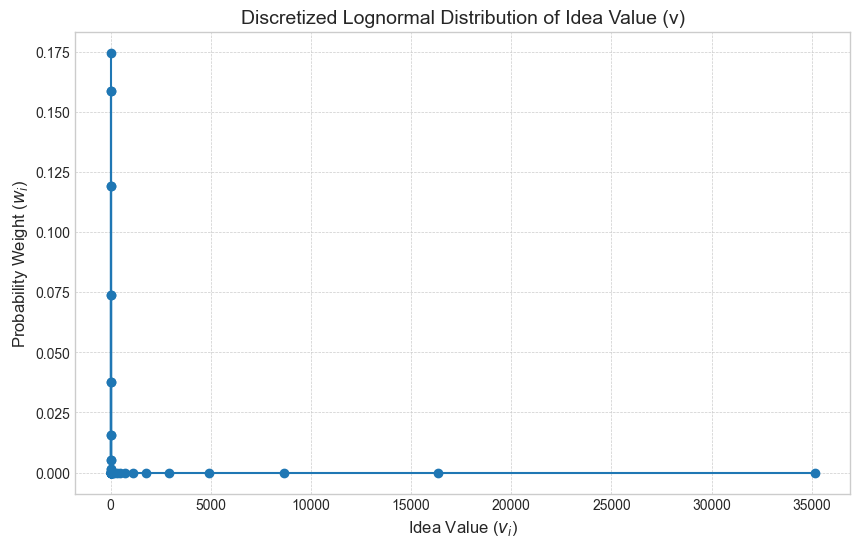

In [5]:
# Execution
n_v = 51
sigma = 3                                                  # Roughly in line with the literature ~2.4-4.3
target_mean = 1.0                                          # Per above
N = 3_300_000                                              # Roughly the amount of patents granted by USPTO 2010-2020

M = max_multiple(sigma, N, target_mean)                    # Ratio to roughly match literature on patent value
sigma_log = sigma_for_target_max(M, n_v)                   # Sigma to produce that ratio just by solving for sigma from my transformation

v_grid, v_weights  = v_dist(n_v, sigma_log, target_mean)   # The innovation idea grid

Building Agent Type Distribution...
Loading R&D data from 'top2000_SB2024.xlsx'
Found 681 US firms in data (the 'tail').
Body_sigma is at 0.54422813424776
Data tail begins at 73.46408583278622 and estimated body ends at 73.65165203009721, close enough!


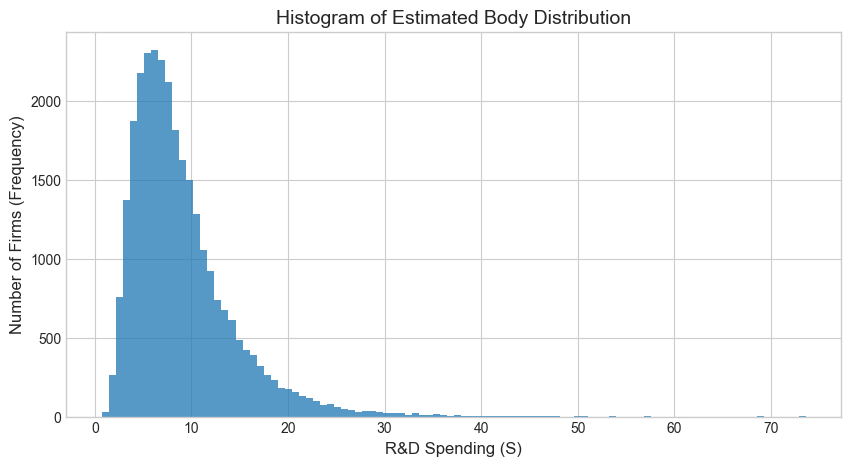

Fitting Pareto distribution to the tail of the estimated full spending data...
Power law fit results: alpha = 1.7548, xmin = 73.46, p_tail = 0.0227
Creating empirical CDF...
Empirical basis for Type distribution created


In [6]:
# ===================================================================
# AGENT TYPE DISTRIBUTION (F(theta))
# ===================================================================
# This section calibrates the distribution of agent types, theta, from
# real-world R&D spending data, with a bit of random noise since spending isn't
# a 1-to-1 proxy for ability, but I assume it is close enough.
# Estimates for body: https://ncses.nsf.gov/surveys/business-enterprise-research-development/2022
# Data for tail: https://iri.jrc.ec.europa.eu/scoreboard/2024-eu-industrial-rd-investment-scoreboard

def type_distribution(data_path, total_firms, total_rd_spending, eur_usd_rate=1.09, body_sigma=0.8):
    
    print(f"Building Agent Type Distribution...")
    print(f"Loading R&D data from '{data_path.name}'")
    df = pd.read_excel(data_path)

    # Filter for US firms and extract R&D spending column
    df = df[df['Country'] == 'US'].copy()
    rd_col = df.columns[5] 
    S_tail = pd.to_numeric(df[rd_col], errors="coerce").dropna().to_numpy()           # Since this is only the top firms, I am going to use this for the tail
    S_tail = S_tail[S_tail > 0] * eur_usd_rate                                        # Convert it to USD since it is in EUR originally
    S_tail.sort()
    
    N_data = len(S_tail)                                                              # How many US companies are in this data
    xmin_tail = float(S_tail.min())                                                   # Where the tail starts
    print(f"Found {N_data} US firms in data (the 'tail').")

    # Decompose Total Economy into Body and Tail 
    T_tail = float(S_tail.sum())                                                      # Total R&D spending in the tail
    N_body = int(total_firms - N_data)                                                # I found data for roughly the total number of R&D active firms in US
    T_body = total_rd_spending - T_tail                                               # Going to make up estimate data for the non-tail firms and this is their total spending
    body_mean = T_body / N_body if N_body > 0 else 0                                  # The average distributed to these 'body' firms I will estimate

    mm = max_multiple(0.57, N_body, body_mean)                                        # Estimating the sigma for this body part
    body_sigma = sigma_for_target_max(mm, 8)                                          # 0.57 and 8 were chosen by trial and error, should automate this in future
    print(f"Body_sigma is at {body_sigma}")

    # Synthetically generate body data based on what I have
    rng = np.random.default_rng(seed)
    body_mu = np.log(body_mean) - 0.5 * body_sigma**2 if body_mean > 0 else -np.inf   # Get mu of log-normal dist
    S_body = rng.lognormal(body_mu, body_sigma, N_body)                               # Generate log-normal dist since it fits with pareto tail
    
    print(f'Data tail begins at {xmin_tail} and estimated body ends at {S_body.max()}, close enough!')

    # Histogram of body
    plt.figure(figsize=(10, 5))
    plt.hist(S_body, bins=100, alpha=0.75)
    plt.title("Histogram of Estimated Body Distribution")
    plt.xlabel("R&D Spending (S)")
    plt.ylabel("Number of Firms (Frequency)")
    plt.show()

    # Combine the estimated body and the tail data
    S = np.concatenate([S_body, S_tail])
    S.sort()
    N = len(S)

    print("Fitting Pareto distribution to the tail of the estimated full spending data...")
    fit = powerlaw.Fit(S, discrete=False, xmin=xmin_tail)                            # Guess that the tail begins where the tail begins
    alpha = fit.alpha                                                                # The alpha of the tail
    xmin = fit.xmin                                                                  # Actual tail beginning
    p_tail = len(S[S >= xmin]) / N                                                   # Where the tail begins
    print(f"Power law fit results: alpha = {alpha:.4f}, xmin = {xmin:,.2f}, p_tail = {p_tail:.4f}")

    # Now need to convert this spending data into abstract 'types'
    s0 = xmin
    theta = S / (S + s0)                                                             # Transformation is monotonic and theta -> 1 as S -> inf
    theta_u = 0.5                                                                    # By construction, since s0 = xmin, keeps it simple

    mask_tail = (S >= xmin)
    theta_body = np.sort(theta[~mask_tail])
    n_body = len(theta_body)
    q_body = 1.0 - p_tail

    # Construct the Empirical CDF from the 'data'
    print(f'Creating empirical CDF...')
    def F_theta(t: float) -> float:
        "Computes the empirical CDF F(theta) for a given type t."
        if t <= 0.0: 
            return 0.0
        if t < theta_u:
            idx = np.searchsorted(theta_body, t, side="right")
            return q_body * (idx / n_body)
        if t < 1.0:
            survivor_share = p_tail * ((1.0 - t) / t)**(alpha-1)
            return 1.0 - survivor_share
        return 1.0
    
    details = { "p_tail": p_tail, "q_body": q_body, "theta_u": theta_u, "n_body": n_body, "theta_body": theta_body }
    print("Empirical basis for Type distribution created")
    
    return F_theta, S, fit, details

# Execution 
DATA_FILENAME = "data/top2000_SB2024.xlsx"
DATA_PATH = Path.cwd() / DATA_FILENAME

# Note: N_total_firms is now defined in this cell for clarity, based on the data sources above.
N_total_firms = 29_990
TOTAL_RD_SPENDING = 841_141  # In millions USD

# Build the distribution
F_theta, S_combined, powerlaw_fit, dist_details = type_distribution(
    data_path=DATA_PATH,
    total_firms=N_total_firms,
    total_rd_spending=TOTAL_RD_SPENDING
)

Creating Continuous Distribution...
Injecting lognormal noise with sigma=0.2...
Plotting empirical (no noise) vs. stochastic model (with noise)...


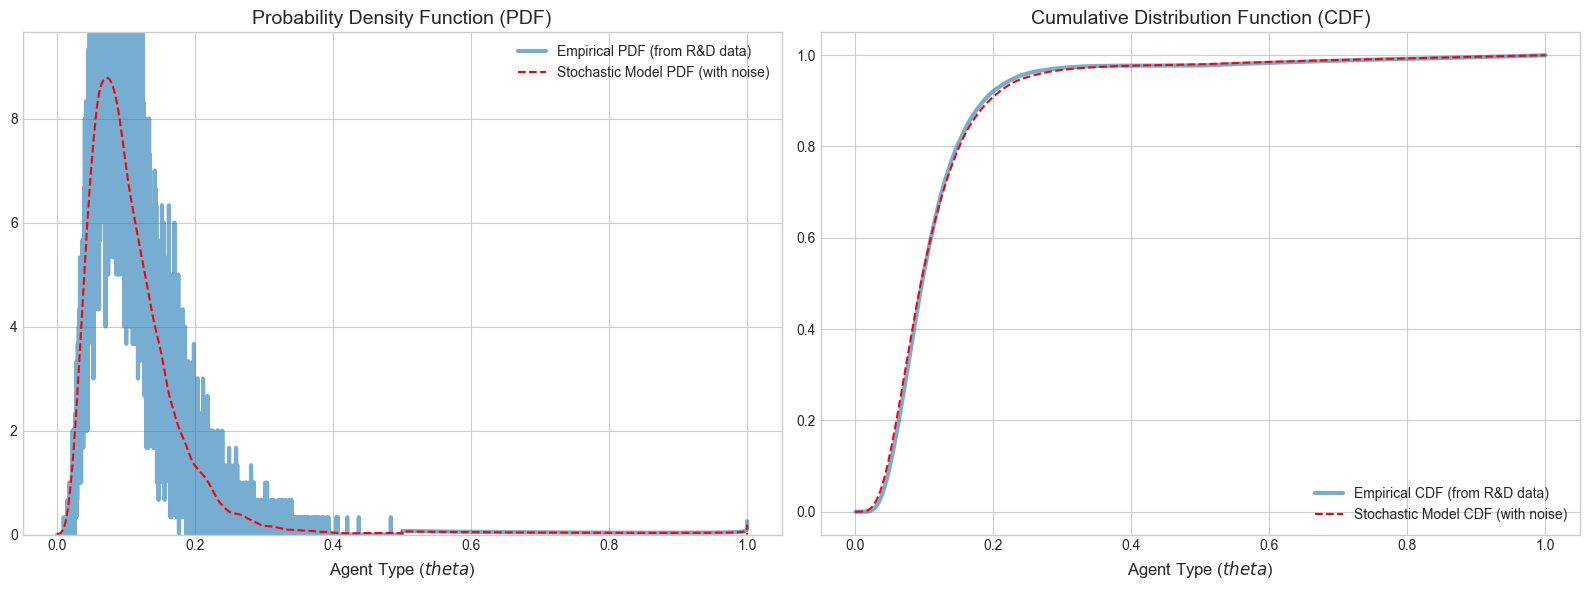

In [7]:
# ===================================================================
# STOCHASTIC CONTINUOUS TYPE DISTRIBUTIONS f(theta) and F(theta)
# ===================================================================

# Methodology and Citations
# I now create the model's final continuous type distribution. I take the
# empirical theta from the previous step and inject lognormal noise to capture
# unobserved factors (e.g., luck, R&D efficiency).
#
# From this new stochastic data, I construct the type distribution using a hybrid,
# semi-parametric approach. This is a standard and robust practice for modeling
# distributions with heavy tails, particularly in quantitative finance and econometrics.
#
# CITE: McNeil, A. J., Frey, R., & Embrechts, P. (2015). Quantitative risk management.
# CITE: Carapella, M., & Giammarino, R. (2014). A composite model for stock returns.
# Comin and Philippon (2005) studies the volatility of firm growth. They find that the 
# cross-sectional standard deviation of firm-level growth rates in the US has historically 
# been around 10% to 15%

def create_stochastic_continuous_distribution(
    rd_theta_mapping,            # The deterministic mapping to theta from the R&D data
    F_empirical,                 # The empirical CDF of the deterministic theta from cell above
    fit_obj,                     # The powerlaw fit object from the original data
    noise_level=0.2,             # The std. dev. of the lognormal shock, the noise mentioned in description above
    n_grid_points=20001,
):
    print(f"Creating Continuous Distribution...")

    # Inject Lognormal Noise
    print(f"Injecting lognormal noise with sigma={noise_level}...")
    rng = np.random.default_rng(seed)
    epsilon = rng.lognormal(mean=-(noise_level**2 / 2), sigma=noise_level, size=len(rd_theta_mapping))     # Generating distribution of the noise, mean = 1
    theta_stochastic = rd_theta_mapping * epsilon                                                          # Add noise to every mapping    
    theta_stochastic = np.clip(theta_stochastic, 0, 0.9999)                                                # Type 1 creates problems, but prob of being 1 so low it doesn't matter to drop it
    theta_stochastic.sort()

    # Build the Hybrid PDF/CDF from the NEW Noisy Data
    theta_u = 0.5                                                                                          # Same reason as before
    q_body = np.sum(theta_stochastic < theta_u) / len(theta_stochastic)
    p_tail = 1.0 - q_body
    theta_body_stochastic = theta_stochastic[theta_stochastic < theta_u]
    alpha = fit_obj.alpha                                                                                  # Tail thickness found above

    if len(theta_body_stochastic) > 1:
        kde = gaussian_kde(theta_body_stochastic, bw_method=0.1)                                           # Using Gaussian KDE to estimate dist from new data
    else:
        kde = None

    theta_grid = np.linspace(0.0, 1.0, n_grid_points)                                                      # Discrete grid to build with
    body_mask = (theta_grid < theta_u)

    if kde:
        kde_pdf_raw = kde(theta_grid)                                                                      # Build PDF from KDE!
        kde_pdf_raw[theta_grid >= theta_u] = 0                                                             # Will handle tail separately
        mass_raw_body = np.trapz(kde_pdf_raw, theta_grid)
        kde_pdf_scaled = kde_pdf_raw * (q_body / mass_raw_body)
    else:
        kde_pdf_scaled = np.zeros_like(theta_grid)

    with np.errstate(divide='ignore', invalid='ignore'):
        pareto_tail_pdf = p_tail * (alpha - 1.0) * ((1.0 - theta_grid)**(alpha - 2.0)) * (theta_grid**(-alpha))      # Handle tail points
        pareto_tail_pdf = np.nan_to_num(pareto_tail_pdf, nan=0.0, posinf=0.0, neginf=0.0)

    f_continuous_values = np.where(body_mask, kde_pdf_scaled, pareto_tail_pdf)
    f_continuous_values[f_continuous_values < 0] = 0
    f_continuous_values /= np.trapz(f_continuous_values, theta_grid)

    # Continuous distributions I can use where I can feed any value [0, 1] and get a density or mass!
    def f_continuous(t):
        return np.interp(t, theta_grid, f_continuous_values)

    F_continuous_values = np.cumsum(f_continuous_values) * (theta_grid[1] - theta_grid[0])

    def F_continuous(t):
        return np.interp(t, theta_grid, F_continuous_values)

    # Visuals for Verification
    print("Plotting empirical (no noise) vs. stochastic model (with noise)...")
    F_empirical_values = np.array([F_empirical(t) for t in theta_grid])
    f_empirical_values = np.gradient(F_empirical_values, theta_grid)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # PDF Plot
    ax1.plot(theta_grid, f_empirical_values, label='Empirical PDF (from R&D data)', alpha=0.6, lw=3)
    ax1.plot(theta_grid, f_continuous_values, label='Stochastic Model PDF (with noise)', color='red', linestyle='--')
    ax1.set_title('Probability Density Function (PDF)')
    ax1.set_xlabel('Agent Type ($theta$)'); ax1.legend(); ax1.grid(True)
    ax1.set_ylim(0, np.max(f_continuous_values[theta_grid < 0.9])*1.1)

    # CDF Plot
    ax2.plot(theta_grid, F_empirical_values, label='Empirical CDF (from R&D data)', alpha=0.6, lw=3)
    ax2.plot(theta_grid, F_continuous_values, label='Stochastic Model CDF (with noise)', color='red', linestyle='--')
    ax2.set_title('Cumulative Distribution Function (CDF)')
    ax2.set_xlabel('Agent Type ($theta$)'); ax2.legend(); ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    return f_continuous, F_continuous

# Execution

# Recreate the deterministic theta from the previous cell's output for the injection step
rd_theta_mapping = S_combined / (S_combined + powerlaw_fit.xmin)

f, F = create_stochastic_continuous_distribution(
    rd_theta_mapping=rd_theta_mapping,
    F_empirical=F_theta,
    fit_obj=powerlaw_fit,
    noise_level=0.2
)

In [8]:
# ===================================================================
# DIAGNOSTIC: FIRM DISTRIBUTION SUMMARY
# ===================================================================
# This cell provides a quick summary table to help interpret the
# calibrated agent type distribution, F(theta). I calculate how many
# of the total firms have a type greater than a few key thresholds.

def display_firm_distribution_summary(F_func, total_firms, thresholds=None):
    """
    Prints a formatted summary table of the firm distribution.

    Args:
        F_func (callable): The continuous CDF for agent types, F(theta).
        total_firms (float): The total number of firms in the model.
        thresholds (list, optional): A list of theta values to check. 
                                     Defaults to a preset list if None.
    """
    if thresholds is None:
        thresholds = [0.0, 0.05, 0.10, 0.20, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]

    # Calculate the number of firms with a type greater than each threshold
    firms_above = [int((1.0 - F_func(t)) * total_firms) for t in thresholds]
    
    summary_df = pd.DataFrame({
        'Theta Threshold': thresholds,
        'Firms Above This Type': firms_above
    })

    # Apply formatting for a clean display
    print("\n--- Summary of Calibrated Firm Distribution ---")
    format_dict = {'Theta Threshold': '{:.4f}', 'Firms Above This Type': '{:,}'}
    display(summary_df.style.format(format_dict).hide(axis="index"))

# --- Execution ---
# Using the F function and N_total_firms from the previous steps
display_firm_distribution_summary(F_func=F, total_firms=N_total_firms)


--- Summary of Calibrated Firm Distribution ---


Theta Threshold,Firms Above This Type
0.0000,"29,989"
0.0500,"26,196"
0.1000,"13,834"
0.2000,"2,726"
0.2500,"1,432"
0.5000,603
0.7500,263
0.9000,114
0.9500,65
0.9900,18


Discrete theta distribution created with 10000 points.
Sum of weights: 1.0000
Comparing continuous distribution with a discrete approximation using 10000 points.


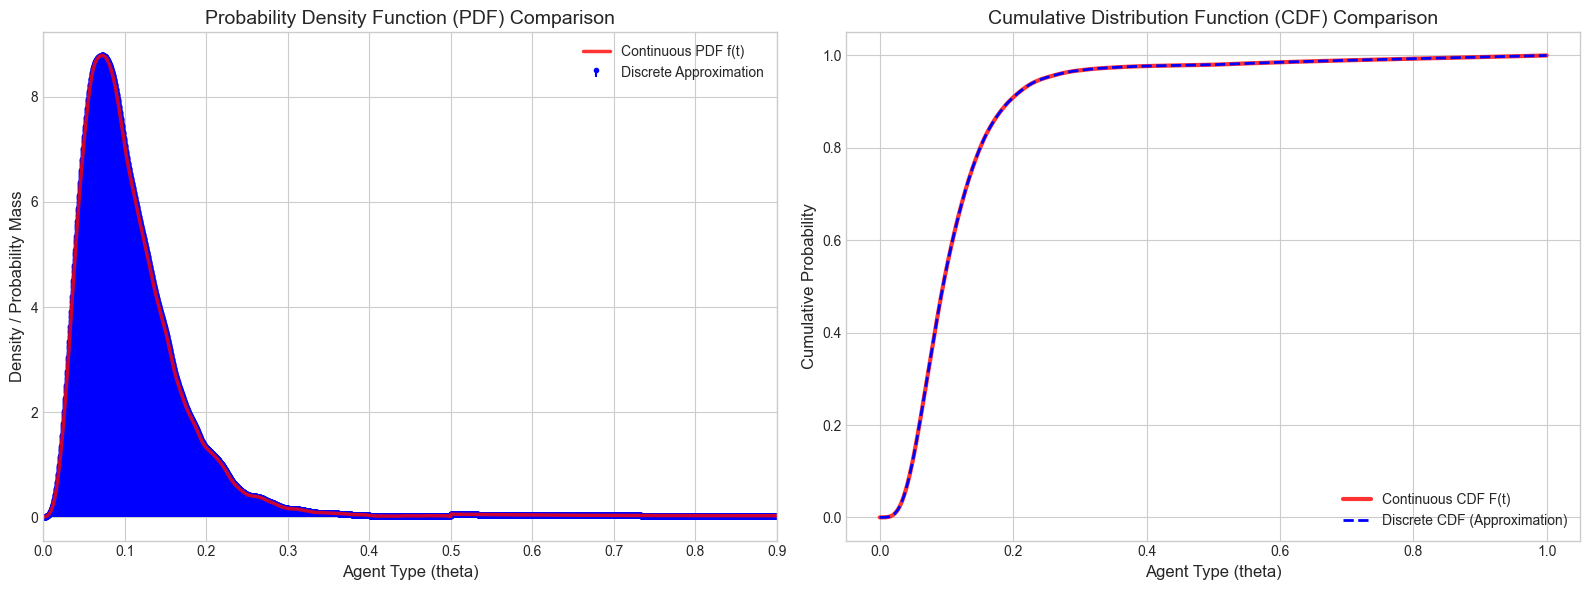


Quantitative Check:
Mean Absolute Error between the two CDFs: 0.000030
The fit is excellent. A low error value confirms the visual match.


In [9]:
# ===================================================================
# VALIDATION: Comparing Continuous vs. Discrete Theta Distribution
# ===================================================================

# Create the Discrete Approximation ---
N_POINTS_DISCRETE = 10000  # Number of points for our approximation.

# Create the grid of points for theta
theta_points = np.linspace(0.0, 1.0, N_POINTS_DISCRETE)

# Get the probability density from your continuous f() at each point
# This gives the *shape* of the distribution.
theta_weights = f(theta_points)

# Normalize the weights so they sum to 1, making it a valid probability distribution
theta_weights /= np.sum(theta_weights)

print(f"Discrete theta distribution created with {N_POINTS_DISCRETE} points.")
print(f"Sum of weights: {np.sum(theta_weights):.4f}") # Should be 1.0000

# Calculate the CDF for Both Versions ---
# Continuous CDF values from your F() function
continuous_cdf_values = F(theta_points)

# Discrete CDF is the cumulative sum of the weights
discrete_cdf_values = np.cumsum(theta_weights)

# --- 3. Plot the Comparison ---
print(f"Comparing continuous distribution with a discrete approximation using {N_POINTS_DISCRETE} points.")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PDF Comparison
ax1.stem(theta_points, theta_weights / (theta_points[1]-theta_points[0]), 'b', markerfmt='.', basefmt=" ", label='Discrete Approximation')
ax1.plot(theta_points, f(theta_points), 'r-', lw=2.5, label='Continuous PDF f(t)', alpha=0.8)
ax1.set_title('Probability Density Function (PDF) Comparison')
ax1.set_xlabel('Agent Type (theta)')
ax1.set_ylabel('Density / Probability Mass')
ax1.legend()
ax1.grid(True)
# Zoom in on the body of the distribution for a clearer view
ax1.set_xlim(0, 0.9)


# CDF Comparison
ax2.plot(theta_points, continuous_cdf_values, 'r-', lw=3, label='Continuous CDF F(t)', alpha=0.8)
ax2.plot(theta_points, discrete_cdf_values, 'b--', lw=2, label='Discrete CDF (Approximation)')
ax2.set_title('Cumulative Distribution Function (CDF) Comparison')
ax2.set_xlabel('Agent Type (theta)')
ax2.set_ylabel('Cumulative Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate a Quantitative Error Metric ---
mae = np.mean(np.abs(continuous_cdf_values - discrete_cdf_values))
print(f"\nQuantitative Check:")
print(f"Mean Absolute Error between the two CDFs: {mae:.6f}")
if mae < 0.001:
    print("The fit is excellent. A low error value confirms the visual match.")
else:
    print("The error is a too high. Consider increasing N_POINTS_DISCRETE.")

In [10]:
# ===================================================================
# USEFUL: Get a inverse function for F, this will come in handy later!
# ===================================================================

interp_grid = np.linspace(0.0, 1.0, N_POINTS_DISCRETE)         # Create a fine grid of theta values for interpolation

cdf_values = F(interp_grid)                                    # Evaluate F on this grid

# Mapping from cdf_values (y-axis) back to the grid (x-axis).
F_inv = interp1d(
    cdf_values,                                                # The 'x' values for our new function
    interp_grid,                                               # The 'y' values our new function will return
    bounds_error=False,                                        # Don't throw an error for values outside the range
    fill_value=(0.0, 1.0)                                      # Instead, return the min or max value
)

# Sanity check: example, to find the median (50th percentile):
median_theta = F_inv(0.5)
print(f"The median theta is: {median_theta:.4f}, consistent with graphs above")

The median theta is: 0.0947, consistent with graphs above


In [11]:
# ===================================================================
# SUBJECTIVE WINNING PROBABILITY p(theta, v)
# ===================================================================
# This section defines the perceived probability that an agent of a given
# type (theta) will win the innovation race for an idea of value (v).

# The core assumption is that an agent's perception of their competition
# changes with their own type. High-theta agents perceive a smaller, more
# elite pool of competitors, while low-theta agents perceive the entire market.

# To make this computationally efficient, I use a class that pre-calculates
# the entire probability curve for a given 'v' the first time it's needed,
# and caches it. Subsequent calls are near-instantaneous interpolations.

# Chowdhury, S.M., Sheremeta, R.M. A generalized Tullock contest. Public Choice 147, 413–420 (2011). https://doi.org/10.1007/s11127-010-9636-3
# Hall, B. H., Griliches, Z., & Hausman, J. A. (1986). Patents and R and D: Is There a Lag?. The Journal of Law, Economics, & Organization, 3(2), 265–283.

class PerceivedProbability:
    
    def __init__(self, agent_types_grid, F_func, inverse_F_func, base_k, max_competitors, min_competitors=25):
        self._agent_types = agent_types_grid
        self._F = F_func
        self._F_inv = inverse_F_func
        self._base_k = base_k
        self._max_n = max_competitors
        self._min_n = min_competitors
        self._cache = {}                                                            # Cache for storing full probability curves for each 'v'

    def _winning_score(self, theta, v):
        """Calculates the competitive score for an agent."""
        k_effective = self._base_k * v                                              # Increasing in v, gives FOSD property from the theory
        return (1 + np.asarray(theta)) ** k_effective                               # Monotonic scores, consistent with theory

    def _get_perceived_n(self, theta):
        """Calculates the number of competitors an agent of type theta perceives."""
        perceived_n = self._max_n - (self._max_n - self._min_n) * self._F(theta)    # A linear mapping from CDF value to number of firms where F(theta)=0 -> max_n competitors; F(theta)=1 -> min_n competitors.
        return int(max(perceived_n, self._min_n))

    def _generate_curve(self, v):
        """The core, slow calculation that is performed only once per v."""
        probabilities = np.zeros_like(self._agent_types)                       # Perceived probability for each type
        k_effective = self._base_k * v

        for i, theta in enumerate(self._agent_types):
            n_perceived = self._get_perceived_n(theta)                         # How many competitors each type believes they will be competing with
            
            start_quantile = self._F(max(0, theta))                            # Define the market this agent perceives, they assume they are marginal agent
            perceived_quantiles = np.linspace(start_quantile, 1.0, n_perceived)   
            perceived_market_types = self._F_inv(perceived_quantiles)          # Their beliefs are rational given the actual distribution

            log_my_score = k_effective * np.log(1 + theta)                     # Work in logs because some values of v are WAY larger

            log_total_competitor_score_contributions = k_effective * np.log(1 + perceived_market_types)
            
            all_log_scores = np.concatenate(([log_my_score], log_total_competitor_score_contributions))

            max_log = np.max(all_log_scores)                                   # Use the Log-Sum-Exp trick to get the log of the denominator (total score)
            log_denominator = max_log + np.log(np.sum(np.exp(all_log_scores - max_log)))
        
            log_prob = log_my_score - log_denominator                          # Final probability is calculated in log-space then converted back
            probabilities[i] = np.exp(log_prob)                                # Gives the perceived prob based on this!
        return probabilities

    def get_prob(self, theta, v):
        """
        The main public method. Returns p(theta, v) using the cache and interpolation.
        """
        if v not in self._cache:
            self._cache[v] = self._generate_curve(v)                                # If v is new, run the slow generation and cache the result.
        
        return np.interp(theta, self._agent_types, self._cache[v])                  # If v is not new, no need to run it again, pull from cache

def setup_probability_function(plot=True, table=True):
    """
    Function to build and visualize the probability function object.
    """
    # Define Calibratable Parameters
    AGENT_TYPES_GRID = np.linspace(0.0, 1, 500)
    BASE_K_PARAM = 1.25
    MIN_COMPETITORS = 5

    # Instantiate and Return the Function
    model = PerceivedProbability(
        agent_types_grid=AGENT_TYPES_GRID,
        F_func=F,
        inverse_F_func = F_inv,
        base_k=BASE_K_PARAM,
        max_competitors=N_total_firms,
        min_competitors=MIN_COMPETITORS
    )
    
    # Create a simple function to be called in main script
    p = model.get_prob

    if plot or table:
        print(r"Visualizing Subjective Winning Probability Function $p(\theta, v)$")
        if plot:
            v_values_to_plot = [0.01, 0.1, 0.5, 0.75, 1, 5, 10]
            fig, ax = plt.subplots(figsize=(12, 8))
            
            for v in v_values_to_plot:
                # The first call to p() with a new 'v' will trigger the slow calculation.
                # Subsequent calls will be fast.
                prob_curve = [p(theta, v) for theta in AGENT_TYPES_GRID]
                ax.plot(AGENT_TYPES_GRID, prob_curve, label=f'v = {v}', lw=2.5)
    
            ax.set_title('Subjective Winning Probability vs. Agent Type', fontsize=16)
            ax.set_xlabel(r'Agent Type ($\theta$)', fontsize=12)
            ax.set_ylabel(r'Probability of Winning $p(theta, v)$', fontsize=12)
            ax.legend(title='Idea Value (v)', fontsize=10)
            ax.set_xlim(0.8, 1) # Focus on high-skill agents where probability is non-trivial
            ax.set_ylim(bottom=0)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.show()
    
        if table:
            v_values = [0.001, 0.1, 0.5, 0.75, 1, 5, 10, 20, 100, 1000, 5000, 10000, int(max(v_grid))]
            theta_thresholds = [0.0, 0.05, 0.10, 0.20, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9995, 0.9999]
    
            table_data = {}
            for v in v_values:
                table_data[f'v={v}'] = [p(theta, v) for theta in theta_thresholds]
                
            df = pd.DataFrame(table_data, index=theta_thresholds)
            df.index.name = r'$\theta$'
            formatted_table = df.style.format("{:.2%}") \
                                      .format_index("{:.4f}") \
                                      .set_caption(r"Perceived winning Probability $p(\theta, v)$")
            
            display(formatted_table)

    return p

# Execution
p = setup_probability_function(plot=False, table=True)

Visualizing Subjective Winning Probability Function $p(\theta, v)$


,v=0.001,v=0.1,v=0.5,v=0.75,v=1,v=5,v=10,v=20,v=100,v=1000,v=5000,v=10000,v=35165
$\theta$,,,,,,,,,,,,,
0.0000,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.0500,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.1000,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.2000,0.04%,0.04%,0.03%,0.03%,0.03%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.2500,0.07%,0.07%,0.06%,0.06%,0.06%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.5000,0.16%,0.16%,0.15%,0.14%,0.14%,0.06%,0.02%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
0.7500,0.37%,0.37%,0.36%,0.35%,0.34%,0.23%,0.14%,0.04%,0.00%,0.00%,0.00%,0.00%,0.00%
0.9000,0.83%,0.83%,0.82%,0.81%,0.80%,0.70%,0.57%,0.38%,0.01%,0.00%,0.00%,0.00%,0.00%
0.9500,1.41%,1.41%,1.40%,1.39%,1.39%,1.29%,1.18%,0.98%,0.16%,0.00%,0.00%,0.00%,0.00%


In [12]:
# ===================================================================
# INNOVATION COST FUNCTION c(theta, v)
# ===================================================================

# --- Define Calibratable Parameters ---

# Target for E[c/v]. A value of 0.50 implies a 100% gross rate of return for a
# successful project. This is a plausible benchmark for high-risk, patent-protected
# innovation, supported by studies finding very high private returns to R&D.
# CITE: Schankerman, M. (1981). The Effects of Double-Counting and Expensing on the Measured Returns to R&D.
TARGET_AVG_COST_SHARE = 0.50

# The minimum, inescapable cost share. This represents a conservative estimate of
# non-research overhead, regulatory, and administrative costs as a share of total
# project value, based on detailed cost breakdowns in the pharmaceutical industry.
# CITE: DiMasi, J. A., et al. (2016). Innovation in the pharmaceutical industry: New estimates of R&D costs.
C_MIN_COST = 0.05

# Exponent on the (1 - theta) term. A value of 3.0 assumes cost advantages for
# high-skill firms are steeper than a standard quadratic model (gamma=2.0), reflecting
# a strong Schumpeterian framework where capable innovators are dramatically more efficient.
# CITE: Cohen, W. M. (2010). Fifty Years of Empirical Studies of Innovative Activity and Performance.
GAMMA_C_COST = 3.0

def setup_cost_function(f_dist, target_avg_cost_share, c_min, gamma_c):
    """
    Calibrates kappa_c and returns a vectorized innovation cost function.
    """
    print("--- Calibrating Innovation Cost Function c(theta, v) ---")
    
    # I calibrate kappa_c by solving: target_avg_cost_share = c_min + kappa_c * E[(1 - theta)**gamma_c]
    integrand = lambda t: ((1.0 - t)**gamma_c) * f_dist(t)
    E_term, _ = quad(integrand, 0.0, 1.0)

    if E_term <= 0:
        raise ValueError("Calculated E[(1-theta)^gamma_c] is not positive. Check f(theta).")

    kappa_c = (target_avg_cost_share - c_min) / E_term
    
    print(f"  Target E[c/v]: {target_avg_cost_share:.4f}")
    print(f"  Calibrated kappa_c: {kappa_c:.4f}")

    def c(theta, v):
        """Calculates innovation cost for an agent of type theta and idea value v."""
        theta_arr = np.asarray(theta)
        cost_share = c_min + kappa_c * np.power(1.0 - theta_arr, gamma_c)
        return cost_share * v

    return c

# --- Execution ---
c = setup_cost_function(
    f_dist=f,
    target_avg_cost_share=TARGET_AVG_COST_SHARE,
    c_min=C_MIN_COST,
    gamma_c=GAMMA_C_COST
)

--- Calibrating Innovation Cost Function c(theta, v) ---
  Target E[c/v]: 0.5000
  Calibrated kappa_c: 0.6351


In [13]:
# ===================================================================
# REGULATOR FEE SCHEDULE Z(beta, v)
# ===================================================================

# --- Define Calibratable Parameters ---
# The parameters for the fee schedule are calibrated by analogy to the market
# for Intellectual Property (IP) insurance, where premiums are a function of the
# asset's value and the desired level of protection.

# The baseline premium rate. Industry data shows that annual premiums for IP
# enforcement and defense insurance are typically 1-4% of the policy limit.
# CITE: Marsh. (n.d.). IP Protect: Addressing the Intellectual Property Coverage Gap.
# CITE: BlueIron IP. (2024, September 9). What does patent insurance cost?.
ZETA = 0.04

# The exponent for beta. M > 1 ensures the fee is convex, meaning the marginal
# cost of protection increases as protection becomes more complete. A value of 1.5
# is chosen to reflect a significant, but not overly aggressive, convexity.
M = 1.5

def setup_fee_schedule(zeta, m):
    """
    Creates the regulator's fee schedule function, Z(beta, v).

    Args:
        zeta (float): The scalar for the fee function, interpretable as a premium rate.
        m (float): The exponent for beta, ensuring convexity (m > 1).

    Returns:
        A callable function, Z(beta, v), representing the fee.
    """
    print("--- Defining Regulator Fee Schedule Z(beta, v) ---")
    print(f"  Fee parameters calibrated from IP insurance data: zeta={zeta}, m={m}")

    def Z(beta, v):
        """
        Calculates the regulator's fee based on patent breadth and idea value.
        """
        return (zeta * (np.asarray(beta) ** m)) * v

    return Z

# --- Execution ---
Z = setup_fee_schedule(zeta=ZETA, m=M)

--- Defining Regulator Fee Schedule Z(beta, v) ---
  Fee parameters calibrated from IP insurance data: zeta=0.04, m=1.5


In [14]:
# === PATCH: drop-in replacement for the revenue work in InvestmentCutoffSolver ===
class InvestmentCutoffSolver:
    def __init__(self, p_func, c_func, Z_func, f_dist, F_dist, n_total_firms, tau_d, tau_f, theta_points, theta_weights):
        self.p, self.c, self.Z, self.f, self.F = p_func, c_func, Z_func, f_dist, F_dist
        self.n_total_firms = n_total_firms
        self.tau_d, self.tau_f = tau_d, tau_f
        self._v = None
        self._bar_beta = None
        self._profit_shifted = (self.tau_d > self.tau_f)
        
        # --- MODIFICATION: Store discrete distribution for fast sums ---
        self.theta_points = theta_points
        self.theta_weights = theta_weights
        
        self._rev_cache = {}  # cache: θ̃ -> total revenue for current (v, β̄)

    def _total_revenue_at(self, theta_tilde):
        # cache is specific to the current (v, β̄)
        key = float(theta_tilde)
        if key in self._rev_cache:
            return self._rev_cache[key]

        # mass & imitator profit are constants with respect to integration variable
        mass_of_investors = int((1.0 - self.F(theta_tilde)) * self.n_total_firms)
        if mass_of_investors < 1:
            self._rev_cache[key] = 0.0
            return 0.0

        imitator_profit = (1.0 - self._bar_beta) * self._v / mass_of_investors

        # --- MODIFICATION: Replace QUAD with fast discrete SUM ---
        # 1. Define the function to be summed (the integrand)
        def integrand(th_investor):
            innov_taxable = (self.c(th_investor, self._v) if self._profit_shifted else self._v) * self._bar_beta
            win_prob = self.p(th_investor, self._v)
            expected_tax_base_per_firm = win_prob * innov_taxable + (1.0 - win_prob) * imitator_profit
            return self.tau_d * self.n_total_firms * expected_tax_base_per_firm

        # 2. Select the relevant points and weights for the integration range
        investor_mask = self.theta_points >= theta_tilde
        relevant_thetas = self.theta_points[investor_mask]
        relevant_weights = self.theta_weights[investor_mask]
        
        # 3. Calculate the weighted sum (Note: weights already include the probability f(theta))
        total_revenue = np.sum(integrand(relevant_thetas) * relevant_weights)
        # --- END MODIFICATION ---

        self._rev_cache[key] = total_revenue
        return total_revenue

    def _get_transfer(self, theta_tilde):
        num_non_investors = int(self.F(theta_tilde) * self.n_total_firms)
        if num_non_investors <= 1:
            return 0.0
        total_revenue = self._total_revenue_at(theta_tilde)
        return total_revenue / num_non_investors

    def _indifference_gap(self, theta_tilde):
        if self._profit_shifted:
            innovator_payoff = self._bar_beta * ((1 - self.tau_f) * (self._v - self.c(theta_tilde, self._v)) +
                                                 (1 - self.tau_d) * self.c(theta_tilde, self._v))
        else:
            innovator_payoff = self._bar_beta * self._v * (1 - self.tau_d)

        mass_of_investors = (1.0 - self.F(theta_tilde)) * self.n_total_firms
        imitator_payoff = (1.0 - self._bar_beta) * self._v / mass_of_investors if mass_of_investors >= 1 else 0.0

        win_prob = self.p(theta_tilde, self._v)
        investing_utility = (win_prob * (innovator_payoff - self.Z(self._bar_beta, self._v)) +
                             (1.0 - win_prob) * imitator_payoff * (1.0 - self.tau_d) -
                             self.c(theta_tilde, self._v))

        transfer_utility = self._get_transfer(theta_tilde)
        return investing_utility - transfer_utility

    def solve(self, v, bar_beta):
        self._v = v
        self._bar_beta = bar_beta
        self._rev_cache.clear()

        gap_at_top = self._indifference_gap(0.999)
        if gap_at_top < 0:
            return 1.0
        gap_at_bottom = self._indifference_gap(0.001)
        if gap_at_bottom > 0:
            return 0.0

        try:
            return brentq(self._indifference_gap, 0.001, 0.999, maxiter=200)
        except (ValueError, RuntimeError):
            return None

In [15]:
# ===================================================================
# Finding the stochastic winner
# ===================================================================
def choose_stochastic_winner(theta_tilde, v, p_func, theta_points):
    """
    Randomly selects ONE winner based on conditional probabilities.
    """
    if theta_tilde >= 1.0: return np.nan

    investor_mask = theta_points >= theta_tilde
    investor_thetas = theta_points[investor_mask]

    if len(investor_thetas) == 0: return np.nan

    investor_probs = p(investor_thetas, v) # Using the main 'p' function
    total_prob_mass = np.sum(investor_probs)

    if total_prob_mass <= 0: return np.nan

    conditional_win_probs = investor_probs / total_prob_mass
    
    conditional_win_probs = np.nan_to_num(conditional_win_probs)
    conditional_win_probs /= np.sum(conditional_win_probs)

    return np.random.choice(investor_thetas, p=conditional_win_probs)

In [16]:
# ===================================================================
# EXAMPLE: Running investment cut off to produce the marginal type
# ===================================================================
cut_off_solver = InvestmentCutoffSolver(p, c, Z, f, F, N_total_firms, tau_d=0.20, tau_f=0.05, theta_points=theta_points, theta_weights=theta_weights)
optimal_theta = cut_off_solver.solve(v=1.0219, bar_beta=0.8)

# Initialize winner variable
theta_winner = None

# Then, if a cutoff was found, choose a winner for this specific scenario
if optimal_theta is not None:
    print(f"The optimal investment cutoff is theta_tilde = {optimal_theta:.6f}")
    theta_winner = choose_stochastic_winner(optimal_theta, 1.0219, p, theta_points)
    if theta_winner is not None:
        print(f"A stochastically chosen winner for this scenario is theta_winner = {theta_winner:.6f}")
else:
    print("No investment cutoff found for this scenario.")

The optimal investment cutoff is theta_tilde = 0.993456
A stochastically chosen winner for this scenario is theta_winner = 0.996900


In [ ]:
# ===================================================================
# 11-A. MASTER PRE-COMPUTATION (OPTIMIZED PARALLEL VERSION)
# ===================================================================
# This version is optimized to use all available CPU cores, significantly
# speeding up the creation of the lookup table. Built for use on 10 cores.

# Define the Helper Function for Parallel Execution
# This function produces the marginal type for a single (tau_d, tau_f) pair.
# Joblib will run many instances of this function in parallel.

def compute_slice_for_taus(tau_d, tau_f):
    """
    Computes slices for BOTH theta_tilde and the pre-randomized theta_winner.
    """
    solver = InvestmentCutoffSolver(p, c, Z, f, F, N_total_firms, tau_d, tau_f, theta_points, theta_weights)
    
    theta_tilde_slice = np.full((len(bar_grid), len(v_grid)), np.nan)
    theta_winner_slice = np.full((len(bar_grid), len(v_grid)), np.nan)

    for k, bar_beta in enumerate(bar_grid):
        for l, v in enumerate(v_grid):
            theta_tilde = solver.solve(v=v, bar_beta=bar_beta)
            
            if theta_tilde is not None and 0 < theta_tilde < 1:
                theta_tilde_slice[k, l] = theta_tilde
                
                stochastic_winner = choose_stochastic_winner(theta_tilde, v, p, theta_points)
                theta_winner_slice[k, l] = stochastic_winner

    return theta_tilde_slice, theta_winner_slice

# Setup and Run the Parallel Computation

# Define the parameter grids.
tau_d_grid = np.array([0.10, 0.15, 0.20, 0.25, 0.30, 0.35])
tau_f_grid = np.array([0.0, 0.05, 0.10, 0.15])
lookup_table_shape = (len(tau_d_grid), len(tau_f_grid), len(bar_grid), len(v_grid))

# Create a list of all (tau_d, tau_f) pairs to process.
tau_pairs = [(d, f) for d in tau_d_grid for f in tau_f_grid]
num_tasks = len(tau_pairs)

print(f"Starting parallel computation for {num_tasks} (tau_d, tau_f) pairs...")
start_time = time.time()

# Execute the tasks in parallel
results_list = Parallel(n_jobs=-1)(                                            # n_jobs=-1 tells joblib to use all available CPU cores.
    delayed(compute_slice_for_taus)(tau_d, tau_f) 
    for tau_d, tau_f in tqdm(tau_pairs, desc="Processing tau pairs")           # real-time progress bar.
)

end_time = time.time()

minutes = int((end_time - start_time) / 60)
seconds = int(((end_time - start_time) / 60 - int((end_time - start_time) / 60))*60)
    
print(f"Parallel computation complete in {minutes} minutes and {seconds} seconds")

# Assemble the Final Lookup Table to be referenced later
# This step reconstructs the final 4D matrix from the list of 2D slices

theta_tilde_table = np.full(lookup_table_shape, np.nan)
theta_winner_table = np.full(lookup_table_shape, np.nan) 

result_index = 0
for i, tau_d in enumerate(tau_d_grid):
    for j, tau_f in enumerate(tau_f_grid):
        tilde_slice, winner_slice = results_list[result_index]
        theta_tilde_table[i, j, :, :] = tilde_slice
        theta_winner_table[i, j, :, :] = winner_slice
        result_index += 1
        
print("Successfully assembled the final lookup table.")

# Save the Final Table so I don't have to run this again, can comment this cell out
SAVE_DIR = ROOT_DIR / "results" / "entry"
SAVE_DIR.mkdir(parents=True, exist_ok=True)
TILDE_PATH = SAVE_DIR / "theta_tilde_lookup_table.npy"
WINNER_PATH = SAVE_DIR / "theta_winner_lookup_table.npy"

np.save(TILDE_PATH, theta_tilde_table)
np.save(WINNER_PATH, theta_winner_table)
print(f"Lookup tables saved to: '{SAVE_DIR}'")

Starting parallel computation for 24 (tau_d, tau_f) pairs...


Processing tau pairs:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
# ===================================================================
# 11-B. LOAD LOOKUP TABLES AND DEFINE HELPERS
# ===================================================================
SAVE_DIR = ROOT_DIR / "results" / "entry"
TILDE_PATH = SAVE_DIR / "theta_tilde_lookup_table.npy"
WINNER_PATH = SAVE_DIR / "theta_winner_lookup_table.npy"

try:
    theta_tilde_table = np.load(TILDE_PATH)
    theta_winner_table = np.load(WINNER_PATH)
    print(f"Successfully loaded lookup tables from '{SAVE_DIR}'")
    print(f"Tilde Table Shape: {theta_tilde_table.shape}")
    print(f"Winner Table Shape: {theta_winner_table.shape}")
except FileNotFoundError:
    print(f"ERROR: Lookup table file not found. Please run the pre-computation cell first.")

# Helper functions to convert a parameter value to its closest grid index
def get_tau_d_index(val, grid=tau_d_grid):
    return np.argmin(np.abs(grid - val))

def get_tau_f_index(val, grid=tau_f_grid):
    return np.argmin(np.abs(grid - val))

def get_bar_beta_index(val, grid=bar_grid):
    return np.argmin(np.abs(grid - val))

def get_v_index(val, grid=v_grid):
    return np.argmin(np.abs(grid - val))

In [ ]:
# Compare the pre-calculated optimal_theta with the value in the table
print(f"Value from your cell: {optimal_theta:.6f}")
print(f"Value from parallel table: {theta_tilde_table[get_tau_d_index(0.20), get_tau_f_index(0.05), get_bar_beta_index(0.8), get_v_index(1.0)]:.6f}")

In [ ]:
# ===================================================================
# REGULATOR'S PROBLEM, WELFARE, AND SOLVER (DISCRETE VERSION)
# ===================================================================

REGULATOR_PREFERENCES = {
    "welfarist_balanced": {"phi": 0.6, "psi": 0.3},
    "pro_innovation":     {"phi": 0.9, "psi": 0.1},
    "public_good":        {"phi": 0.1, "psi": 0.9},
    "utilitarian":        "special_case",
    "rawlsian":           "special_case"
}

class RegulatorModel:

    def __init__(self, p_func, c_func, Z_func, f_dist, F_dist, n_total_firms, tau_d, tau_f, preferences_dict, beta_grid, theta_points, theta_weights, enforce_feasibility=True):
        # Store all necessary functions and parameters
        self.p, self.c, self.Z, self.f, self.F = p_func, c_func, Z_func, f_dist, F_dist
        self.n_total_firms, self.tau_d, self.tau_f = n_total_firms, tau_d, tau_f
        self.preferences = preferences_dict
        self._profit_shifted = (self.tau_d > self.tau_f)
        self.beta_grid = beta_grid
        self.enforce_feasibility = enforce_feasibility
        self.theta_points = theta_points
        self.theta_weights = theta_weights

    def _calculate_all_welfare_components(self, scheme, bar_beta, theta_tilde, theta_winner, v):
        """
        Calculates all welfare components for every feasible beta <= bar_beta.
        This is the core ex-post calculation, performed *after* the winner is known.
        """
        # Determine the feasible set of patent breadths (beta) for the regulator.
        beta = self.beta_grid[self.beta_grid <= bar_beta]
        if len(beta) == 0:
            return None

        # Calculate the number of investors and imitators based on the cutoff.
        num_investors = int((1 - self.F(theta_tilde)) * self.n_total_firms)
        if num_investors < 1: 
            return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        num_imitators = num_investors - 1

        # Calculate Innovator's Utility (U_I)
        #  This is the after-tax profit for the winner, minus fees and R&D cost.
        if self._profit_shifted:
            # Profit-shifting tax scheme
            innovator_payoff = beta * ((1 - self.tau_f) * (v - self.c(theta_winner, v)) +
                                       (1 - self.tau_d) * self.c(theta_winner, v))
        else:
            # Standard tax scheme
            innovator_payoff = beta * v * (1 - self.tau_d)
        
        # The innovator's final utility
        innov_util = innovator_payoff - self.Z(beta, v) - self.c(theta_winner, v)

        # Calculate Total Imitators' Utility (U_M)
        # First, find the average cost of an imitator. An imitator is any firm that invested (theta >= theta_tilde) but did not win.
        investor_mask = self.theta_points >= theta_tilde
        # Find the index of the winner to exclude them from the imitator pool
        winner_idx_in_grid = np.argmin(np.abs(self.theta_points - theta_winner))
        
        # Create a temporary mask to handle the exclusion
        imitator_mask = investor_mask.copy()
        if winner_idx_in_grid < len(imitator_mask):
            imitator_mask[winner_idx_in_grid] = False
        
        # Get the types and probability weights for only the imitators
        imitator_thetas = self.theta_points[imitator_mask]
        imitator_weights = self.theta_weights[imitator_mask]
        total_imitator_prob_mass = np.sum(imitator_weights)

        avg_imitator_cost = 0
        if total_imitator_prob_mass > 0:
            # Calculate the weighted average cost across all imitators
            avg_imitator_cost = np.sum(self.c(imitator_thetas, v) * imitator_weights) / total_imitator_prob_mass
        else:
            avg_imitator_cost = 0

        # Calculate utility for the group of imitators
        imitator_profit_pool = (1 - beta) * v                   # Total revenue available to imitators
        profit_per_imitator = imitator_profit_pool / num_imitators if num_imitators > 0 else 0
        after_tax_profit_per_imitator = profit_per_imitator * (1 - self.tau_d)
        avg_imitator_utility = after_tax_profit_per_imitator - avg_imitator_cost
        imit_util_total = avg_imitator_utility * num_imitators

        # Calculate Public Revenue (R), i.e. the sum of all tax revenues plus the patent fee.

        # Tax from innovator
        innov_taxable_base = self.c(theta_winner, v) if self._profit_shifted else v
        tax_from_innov = self.tau_d * beta * innov_taxable_base
        
        # Foreign taxes, useful for math check later
        if self._profit_shifted:
            innov_taxable_base = self.c(theta_winner, v)
            foreign_tax_paid = self.tau_f * beta * (v - self.c(theta_winner, v))
        else:
            innov_taxable_base = v
            foreign_tax_paid = 0 # No foreign tax in the standard scheme
        
        # Tax from all imitators
        tax_from_imits = self.tau_d * imitator_profit_pool if num_imitators > 0 else 0

        tax_revenue = tax_from_innov + tax_from_imits
        public_revenue = tax_revenue + self.Z(beta, v)         # Fees not used for transfer payments    

        #========================
        # Assertive Sanity Check
        #========================
        innovator_pre_cost_take_home = innovator_payoff - self.Z(beta, v)
        imitators_pre_cost_take_home = after_tax_profit_per_imitator * num_imitators
        total_value_distributed = innovator_pre_cost_take_home + imitators_pre_cost_take_home + tax_revenue + foreign_tax_paid + self.Z(beta, v)
        
        # Check if all elements in the calculated array are close to the scalar v.
        if not np.all(np.isclose(total_value_distributed, v)):
            # If not, raise an error with detailed debug info.
            raise ValueError(
                f"Value conservation error! Sum of payouts does not equal original value v."
                f"  Original v: {v}"
                f"  Calculated Sum: {total_value_distributed}"
            )
        #========================
        # End of Sanity Check 
        #========================

        # Calculate Total Welfare based on the regulator's preference scheme.
        scheme_params = self.preferences[scheme]
        if scheme_params == "special_case":
            if scheme == "utilitarian":
                # Sum of all utilities (innovator, imitators, public revenue)
                welfare = innov_util + imit_util_total + public_revenue
            elif scheme == "rawlsian":
                # Welfare is the utility of the worst-off agent (min of innovator vs avg imitator)
                welfare = np.minimum(innov_util, avg_imitator_utility)
            else:
                welfare = np.zeros_like(beta) # Should not happen
        else:
            # Weighted sum based on phi (private vs. private) and psi (private vs. public)
            phi, psi = scheme_params["phi"], scheme_params["psi"]
            private_welfare = phi * innov_util + (1 - phi) * imit_util_total
            welfare = private_welfare + psi * public_revenue

        # Return all calculated components in a dictionary for the solver.
        return {
            "beta": beta, "innov_util": innov_util, "imit_util_total": imit_util_total,
            "tax_revenue": tax_revenue, "public_revenue": public_revenue, "welfare": welfare
        }

    def solve(self, scheme, bar_beta, theta_tilde, theta_winner, v, enforce_feasibility):
        """Finds the optimal beta_star that maximizes the regulator's welfare function."""
        components = self._calculate_all_welfare_components(scheme, bar_beta, theta_tilde, theta_winner, v)
        if components is None:
            return None, None, None # No solution if components could not be calculated.

        # A feasible solution requires the innovator and imitators to have non-negative utility.
        # This is a participation constraint.
        if self.enforce_feasibility:
            feasible_mask = (components["innov_util"] > 0) & (components["imit_util_total"] > 0)
            if not np.any(feasible_mask):
                return None, None, None
            feasible_welfare = np.where(feasible_mask, components["welfare"], -np.inf)
            optimal_idx = np.argmax(feasible_welfare)
        else:
            optimal_idx = np.argmax(components["welfare"])

        beta_star = components["beta"][optimal_idx]
        tax_revenue_star = components["tax_revenue"][optimal_idx]
        reg_welfare_star = components["welfare"][optimal_idx]
    
        return beta_star, tax_revenue_star, reg_welfare_star

    def debug_solve(self, scheme, bar_beta, theta_tilde, theta_winner, v):
        """Returns a full DataFrame of all welfare components for debugging."""
        components = self._calculate_all_welfare_components(scheme, bar_beta, theta_tilde, theta_winner, v)
        if components is None:
            return pd.DataFrame() # Return empty DataFrame if no components.
        return pd.DataFrame(components)

In [ ]:
# ===================================================================
# EXAMPLE: SOLVING THE REGULATOR'S PROBLEM
# ===================================================================
# This cell demonstrates how to use the RegulatorModel to solve for the
# optimal patent breadth (beta_star) for a single, specific scenario.

# Building on the running example
EXAMPLE_V = 1.0
EXAMPLE_THETA_TILDE = optimal_theta                         # An assumed investment cutoff for this example
EXAMPLE_THETA_WINNER = (optimal_theta + 0.00135)            # Just picked a random number between optimal from above and 1
EXAMPLE_BAR_BETA = 0.8
EXAMPLE_TAU_D = 0.20
EXAMPLE_TAU_F = 0.05

# Initialize the Model ---
# The model is initialized once with all the fixed parameters and functions.
regulator_solver = RegulatorModel(
    p_func=p,
    c_func=c,
    Z_func=Z,
    f_dist=f,
    F_dist=F,
    n_total_firms=N_total_firms,
    tau_d=EXAMPLE_TAU_D,
    tau_f=EXAMPLE_TAU_F,
    preferences_dict=REGULATOR_PREFERENCES,
    beta_grid=beta_grid,
    theta_points=theta_points,
    theta_weights=theta_weights,
    enforce_feasibility=True
)

# Solve for the Optimal Policy
beta_star, tax_revenue_star, reg_welfare_star = regulator_solver.solve(
    scheme='welfarist_balanced',
    bar_beta=EXAMPLE_BAR_BETA,
    theta_tilde=EXAMPLE_THETA_TILDE,
    theta_winner=EXAMPLE_THETA_WINNER,
    v=EXAMPLE_V,
    enforce_feasibility=True
)

# --- Print the Results ---
print("\n--- Regulator Problem Solution (Example) ---")
if beta_star is not None:
    print(f"  Optimal beta_star: {beta_star:.4f}")
    print(f"  Resulting Tax Revenue: {tax_revenue_star:,.4f}")
    print(f"  Resulting Regulator Welfare: {reg_welfare_star:,.4f}")
else:
    print("  No feasible solution found for this scenario.")
print("-" * 44)

# Call the DEBUG solver
debug_table = regulator_solver.debug_solve(
    scheme='welfarist_balanced', bar_beta=EXAMPLE_BAR_BETA,
    theta_tilde=EXAMPLE_THETA_TILDE, theta_winner=EXAMPLE_THETA_WINNER, v=EXAMPLE_V
)

pd.set_option('display.max_rows', None)

# Display the full table
print("Regulator Problem Debug Table")
pd.set_option('display.width', 120) # Widen display for more columns
display(debug_table)

In [ ]:
# ===================================================================
# GOVERNMENT'S PROBLEM AND SOLVER (DISCRETE VERSION)
# ===================================================================

# --- Government Preference Schemes ---
GOVERNMENT_PREFERENCES = {
    "utilitarian":          lambda th: 1.0,
    "elitist":              lambda th: 1.0 + th,
    "strongly_elitist":     lambda th: (1.0 + th)**2,
    "egalitarian":          lambda th: 1.0 / (1.0 + th),
    "strongly_egalitarian": lambda th: 1.0 / (1.0 + th)**2
}

class GovernmentModel:
    def __init__(self, tau_d, tau_f, gov_prefs, reg_prefs, v_grid, v_weights, bar_grid, master_lookup_table, master_winner_table, theta_points, theta_weights, enforce_feasibility=True):
        self.tau_d, self.tau_f = tau_d, tau_f
        self.gov_prefs = gov_prefs
        self.reg_prefs = reg_prefs
        self.v_grid, self.v_weights = v_grid, v_weights
        self.bar_grid = bar_grid

        self.theta_points = theta_points
        self.theta_weights = theta_weights
        idx_d = get_tau_d_index(self.tau_d)
        idx_f = get_tau_f_index(self.tau_f)
        self.theta_tilde_slice = master_lookup_table[idx_d, idx_f, :, :]
        self.theta_winner_slice = master_winner_table[idx_d, idx_f, :, :]
        self.enforce_feasibility = enforce_feasibility
        
        self.regulator_solver = RegulatorModel(p, c, Z, f, F, N_total_firms, tau_d, tau_f, reg_prefs, beta_grid, theta_points, theta_weights, enforce_feasibility=enforce_feasibility)

    def _calculate_welfare_for_v(self, w, regulator_scheme, bar_beta, v, enforce_feasibility):
        idx_bar_beta = get_bar_beta_index(bar_beta)
        idx_v = get_v_index(v)
        theta_tilde = self.theta_tilde_slice[idx_bar_beta, idx_v]
        theta_winner = self.theta_winner_slice[idx_bar_beta, idx_v]
        
        if theta_tilde is None or np.isnan(theta_tilde) or not (0 < theta_tilde < 1):
            return None

        investor_types = AGENT_TYPES_GRID[AGENT_TYPES_GRID >= theta_tilde]
        if len(investor_types) < 1:
            return None

        beta_star, tax_rev_star, reg_welfare_star = self.regulator_solver.solve(
            regulator_scheme, bar_beta, theta_tilde, theta_winner, v, enforce_feasibility=enforce_feasibility
        )
        if beta_star is None:
            return None

        # Call debug_solve to get all welfare components at once
        components_df = self.regulator_solver.debug_solve(regulator_scheme, bar_beta, theta_tilde, theta_winner, v)
        if components_df.empty or not np.any(np.isclose(components_df['beta'], beta_star)):
            return None
        
        optimal_components = components_df[np.isclose(components_df['beta'], beta_star)].iloc[0]
        innov_util = optimal_components['innov_util']
        imit_util = optimal_components['imit_util_total']

        if enforce_feasibility and ((innov_util <= 0) or (imit_util <= 0)):
            return None

        F_theta_tilde = F(theta_tilde)
        num_non_investors = int(F_theta_tilde * N_total_firms)
        transfer = tax_rev_star / num_non_investors if num_non_investors > 0 else 0

        non_investor_mask = self.theta_points < theta_tilde
        total_non_investor_prob_mass = np.sum(self.theta_weights[non_investor_mask])
        avg_w_non_investor = 0.0
        if total_non_investor_prob_mass > 0:
            avg_w_non_investor = np.sum(w(self.theta_points[non_investor_mask]) * self.theta_weights[non_investor_mask]) / total_non_investor_prob_mass

        total_welfare_non_investor = transfer * avg_w_non_investor * num_non_investors

        investor_mask = self.theta_points >= theta_tilde
        num_imitators = int((1 - F_theta_tilde) * N_total_firms) - 1
        total_investor_prob_mass = np.sum(self.theta_weights[investor_mask])
        avg_w_imitator = 0.0
        if num_imitators > 0 and total_investor_prob_mass > 0:
            avg_w_imitator = np.sum(w(self.theta_points[investor_mask]) * self.theta_weights[investor_mask]) / total_investor_prob_mass

        total_welfare_imitator = imit_util * avg_w_imitator

        welfare_for_v = (
            w(theta_winner) * innov_util +
            total_welfare_imitator +
            total_welfare_non_investor
        )

        return {
            "welfare_for_v": welfare_for_v, "theta_tilde": theta_tilde, "theta_winner": theta_winner,
            "beta_star": beta_star, "tax_revenue": tax_rev_star, "transfer": transfer,
            "innov_util": innov_util, "imit_util": imit_util,
            "non_invest_util": transfer * num_non_investors,
            "reg_welfare_for_v": reg_welfare_star
        }
    
    def solve(self, government_scheme, regulator_scheme, enforce_feasibility):
        w = self.gov_prefs[government_scheme]
        results_list = []
        for bar_beta in self.bar_grid:
            expected_welfare_gov = 0.0
            expected_beta_star = 0.0
            expected_reg_welfare = 0.0
            expected_innov_util = 0.0
            expected_non_innov_util = 0.0
            
            for v_idx, v in enumerate(self.v_grid):
                sim_results = self._calculate_welfare_for_v(w, regulator_scheme, bar_beta, v, enforce_feasibility)
                if sim_results:
                    expected_welfare_gov += sim_results["welfare_for_v"] * self.v_weights[v_idx]
                    expected_beta_star += sim_results["beta_star"] * self.v_weights[v_idx]
                    expected_reg_welfare += sim_results["reg_welfare_for_v"] * self.v_weights[v_idx]
                    expected_innov_util += sim_results["innov_util"] * self.v_weights[v_idx]
                    expected_non_innov_util += (sim_results["imit_util"] + sim_results["non_invest_util"]) * self.v_weights[v_idx]
            
            results_list.append({
                'bar_beta': bar_beta, 
                'expected_welfare': expected_welfare_gov,
                'expected_beta_star': expected_beta_star,
                'expected_reg_welfare': expected_reg_welfare,
                'expected_innov_util': expected_innov_util,
                'expected_non_innov_util': expected_non_innov_util
            })

        if not results_list:
            return None, None
        results_df = pd.DataFrame(results_list)
        optimal_row = results_df.loc[results_df['expected_welfare'].idxmax()]
        return optimal_row, results_df

    def debug_solve(self, government_scheme, regulator_scheme):
        w = self.gov_prefs[government_scheme]
        debug_results = []
        for bar_beta in self.bar_grid:
            expected_welfare_gov = 0.0
            expected_beta_star = 0.0
            expected_reg_welfare = 0.0
            expected_innov_util = 0.0
            expected_non_innov_util = 0.0
            
            for v_idx, v in enumerate(self.v_grid):
                sim_results = self._calculate_welfare_for_v(w, regulator_scheme, bar_beta, v, self.enforce_feasibility)
                if sim_results:
                    expected_welfare_gov += sim_results["welfare_for_v"] * self.v_weights[v_idx]
                    expected_beta_star += sim_results["beta_star"] * self.v_weights[v_idx]
                    expected_reg_welfare += sim_results["reg_welfare_for_v"] * self.v_weights[v_idx]
                    expected_innov_util += sim_results["innov_util"] * self.v_weights[v_idx]
                    expected_non_innov_util += (sim_results["imit_util"] + sim_results["non_invest_util"]) * self.v_weights[v_idx]

            debug_results.append({
                'bar_beta': bar_beta, 
                'expected_welfare': expected_welfare_gov,
                'expected_beta_star': expected_beta_star,
                'expected_reg_welfare': expected_reg_welfare,
                'expected_innov_util': expected_innov_util,
                'expected_non_innov_util': expected_non_innov_util
            })
        return pd.DataFrame(debug_results)

In [ ]:
# ===================================================================
# 14. EXECUTION: SOLVING A SINGLE SCENARIO
# ===================================================================
# This block runs the entire model end-to-end for a single, specific
# set of policy parameters and preference schemes to find the optimal
# statutory patent breadth ceiling (bar_beta).

# --- 1. Define the Scenario ---
SCENARIO_TAU_D = 0.20
SCENARIO_TAU_F = 0.05
GOVERNMENT_SCHEME = "egalitarian"
REGULATOR_SCHEME = "welfarist_balanced"

print("--- Running a Single Scenario ---")
print(f"Parameters: tau_d={SCENARIO_TAU_D}, tau_f={SCENARIO_TAU_F}")
print(f"Preferences: Gov='{GOVERNMENT_SCHEME}', Reg='{REGULATOR_SCHEME}'")

# --- 2. Initialize the Government Model ---
# This creates the model instance with the parameters for our specific scenario.
gov_model = GovernmentModel(
    tau_d=SCENARIO_TAU_D, 
    tau_f=SCENARIO_TAU_F,
    gov_prefs=GOVERNMENT_PREFERENCES, 
    reg_prefs=REGULATOR_PREFERENCES,
    v_grid=v_grid, 
    v_weights=v_weights, 
    bar_grid=bar_grid,
    master_lookup_table=theta_tilde_table, 
    master_winner_table=theta_winner_table, 
    theta_points=theta_points, 
    theta_weights=theta_weights,
    enforce_feasibility=True
)

# --- 3. Solve the Model and Display Results ---
# This is the new part that actually runs the simulation for the single case.
start_time = time.time()
optimal_policy, all_bar_beta_results = gov_model.solve(
    government_scheme=GOVERNMENT_SCHEME,
    regulator_scheme=REGULATOR_SCHEME,
    enforce_feasibility=True
)
end_time = time.time()

minutes = int((end_time - start_time) / 60)
seconds = int(((end_time - start_time) / 60 - int((end_time - start_time) / 60))*60)
    
print(f"Total execution time: {minutes} minutes and {seconds} seconds")

print("\n--- Optimal Policy Found ---")
if optimal_policy is not None:
    # Display the best result found
    display(optimal_policy.to_frame().T)
else:
    print("No optimal policy found for this scenario.")
    print(f"      Total execution time: {(end_time - start_time) / 60:.2f} minutes")

# DEBUG (Optional)
# This section can be un-commented to run the debug solver for the same
# scenario to produce a detailed table of intermediate results.

gov_debug_table = gov_model.debug_solve(
    government_scheme=GOVERNMENT_SCHEME,
    regulator_scheme=REGULATOR_SCHEME
)

print("\n--- Government Problem Debug Table (sample) ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 0):
    display(gov_debug_table)

In [ ]:
# ===================================================================
# FINAL EXECUTION (PARALLEL WITH GRANULAR PROGRESS BAR)
# ===================================================================

print("="*60)
print("      STARTING FULL PARALLEL SIMULATION (GRANULAR PROGRESS)")
print("="*60)

# 1. Define a helper function for a SINGLE simulation.
# This is the small unit of work that will be parallelized 600 times.
def run_single_simulation(tau_d, tau_f, gov_name, reg_name):
    """
    Runs one unique simulation and returns the result with its identifying keys.
    """
    # A GovernmentModel is created for each simulation. The overhead is minimal.
    gov_model = GovernmentModel(
        tau_d=tau_d, tau_f=tau_f,
        gov_prefs=GOVERNMENT_PREFERENCES, reg_prefs=REGULATOR_PREFERENCES,
        v_grid=v_grid, v_weights=v_weights, bar_grid=bar_grid,
        master_lookup_table=theta_tilde_table, master_winner_table=theta_winner_table,
        theta_points=theta_points, theta_weights=theta_weights,
        enforce_feasibility=True
    )
    
    optimal_row, full_results_df = gov_model.solve(
        government_scheme=gov_name,
        regulator_scheme=reg_name,
        enforce_feasibility=True
    )
    
    result_dict = {
        'optimal_policy': optimal_row,
        'full_results_df': full_results_df
    }
    
    # Return the keys along with the result for easy assembly later
    return (f"{tau_d:.2f}", f"{tau_f:.2f}", gov_name, reg_name, result_dict)

# 2. Create a flat list of all 600 parameter combinations.
all_simulation_params = []
for tau_d in tau_d_grid:
    for tau_f in tau_f_grid:
        for gov_name in GOVERNMENT_PREFERENCES.keys():
            for reg_name in REGULATOR_PREFERENCES.keys():
                all_simulation_params.append((tau_d, tau_f, gov_name, reg_name))

# 3. Run all 600 simulations in parallel with a single, detailed progress bar.
start_time = time.time()
print(f"Executing {len(all_simulation_params)} individual simulations in parallel...")

results_list = Parallel(n_jobs=-1)(
    delayed(run_single_simulation)(td, tf, gn, rn) 
    for td, tf, gn, rn in tqdm(all_simulation_params, desc="Total Simulation Progress")
)

# 4. Assemble the final nested dictionary from the flat list of results.
all_scenarios_results = {}
for tau_d_key, tau_f_key, gov_name, reg_name, result_data in results_list:
    # Create nested dictionary levels if they don't exist
    if tau_d_key not in all_scenarios_results:
        all_scenarios_results[tau_d_key] = {}
    if tau_f_key not in all_scenarios_results[tau_d_key]:
        all_scenarios_results[tau_d_key][tau_f_key] = {}
    if gov_name not in all_scenarios_results[tau_d_key][tau_f_key]:
        all_scenarios_results[tau_d_key][tau_f_key][gov_name] = {}
    
    # Assign the final result
    all_scenarios_results[tau_d_key][tau_f_key][gov_name][reg_name] = result_data

end_time = time.time()

minutes = int((end_time - start_time) / 60)
seconds = int(((end_time - start_time) / 60 - int((end_time - start_time) / 60))*60)

print("="*60)
print("FULL SIMULATION COMPLETE")
print(f"Total execution time: {minutes} minutes and {seconds} seconds")
print("All results are stored in the 'all_scenarios_results' dictionary.")
print("="*60)

In [ ]:
# ===================================================================
# CELL A: DATA PREPARATION AND VISUALIZATION SETUP
# ===================================================================
# This cell extracts the simulation results from the nested dictionary 
# into a clean pandas DataFrame, which is the standard for data 
# analysis and plotting in Python.

print("Preparing data for visualization...")

# Flatten the nested dictionary into a list of records
records = []
for tau_d_key, tau_f_data in all_scenarios_results.items():
    for tau_f_key, gov_data in tau_f_data.items():
        for gov_name, reg_data in gov_data.items():
            for reg_name, result in reg_data.items():
                optimal_policy = result['optimal_policy']
                if optimal_policy is not None:
                    record = {
                        'tau_d': float(tau_d_key),
                        'tau_f': float(tau_f_key),
                        'gov_scheme': gov_name,
                        'reg_scheme': reg_name,
                        'optimal_bar_beta': optimal_policy['bar_beta'],
                        'max_expected_welfare': optimal_policy['expected_welfare'],
                        'expected_beta_star_at_opt': optimal_policy['expected_beta_star'],
                        'expected_reg_welfare_at_opt': optimal_policy['expected_reg_welfare'],
                        'expected_innov_util_at_opt': optimal_policy['expected_innov_util'],
                        'expected_non_innov_util_at_opt': optimal_policy['expected_non_innov_util']
                    }
                    records.append(record)

# Create the master DataFrame
results_df = pd.DataFrame(records)

# Add a 'tax_differential' column, as this is a key policy variable
results_df['tax_differential'] = results_df['tau_d'] - results_df['tau_f']

print("Master DataFrame created with the following columns:")
print(results_df.head())

In [ ]:
# ===================================================================
# BASELINE MODEL
# Calculates outcomes for a baseline scenario where patent breadth (beta)
# is fixed at 1, providing a stable reference for comparison.
# ===================================================================

class BaselineModel:
    """
    Calculates all economic outcomes for a baseline scenario where beta is fixed at 1.
    This provides a non-optimized reference point to evaluate the main model's performance.
    """
    def __init__(self, tau_d, tau_f, gov_prefs, v_grid, v_weights, master_lookup_table, master_winner_table, theta_points, theta_weights):
        # Store key parameters and distributions
        self.tau_d = tau_d
        self.tau_f = tau_f
        self.gov_prefs = gov_prefs
        self.v_grid = v_grid
        self.v_weights = v_weights
        self.theta_points = theta_points
        self.theta_weights = theta_weights
        self._profit_shifted = (self.tau_d > self.tau_f)

        # In the baseline, we assume firms invest based on bar_beta = 1.
        # We fetch the pre-computed investment cutoffs for this specific case.
        idx_d = get_tau_d_index(self.tau_d)
        idx_f = get_tau_f_index(self.tau_f)
        idx_bar_beta_one = get_bar_beta_index(1.0)
        self.theta_tilde_for_v = master_lookup_table[idx_d, idx_f, idx_bar_beta_one, :]
        self.theta_winner_for_v = master_winner_table[idx_d, idx_f, idx_bar_beta_one, :]


    def _calculate_components_for_v(self, w, v):
        """
        Calculates all welfare components for a single idea value 'v' under the
        fixed condition that beta = 1.
        """
        # Get Investment Cutoff and Simulate Winner
        idx_v = get_v_index(v)
        theta_tilde = self.theta_tilde_for_v[idx_v]
        theta_winner = self.theta_winner_for_v[idx_v]

        if np.isnan(theta_tilde) or np.isnan(theta_winner):
            return None # Scenario leads to no investment, skip.

        # Calculate All Components with beta = 1
        beta = 1.0

        # Innovator's Utility: They receive the full (after-tax) value of the innovation.
        if self._profit_shifted:
            innovator_payoff = beta * ((1 - self.tau_f) * (v - c(theta_winner, v)) + (1 - self.tau_d) * c(theta_winner, v))
        else:
            innovator_payoff = beta * v * (1 - self.tau_d)
        innov_util = innovator_payoff - Z(beta, v) - c(theta_winner, v)

        # Imitators' Utility: They get zero revenue but still incurred R&D costs.
        num_investors = int((1 - F(theta_tilde)) * N_total_firms)
        num_imitators = num_investors - 1

        investor_mask = self.theta_points >= theta_tilde
        winner_idx_in_grid = np.argmin(np.abs(self.theta_points - theta_winner))

        imitator_mask = investor_mask.copy()
        imitator_mask[winner_idx_in_grid] = False # Exclude the winner

        imitator_thetas = self.theta_points[imitator_mask]
        imitator_weights = self.theta_weights[imitator_mask]

        avg_imitator_cost = 0
        if np.sum(imitator_weights) > 0:
            avg_imitator_cost = np.sum(c(imitator_thetas, v) * imitator_weights) / np.sum(imitator_weights)

        imit_util_total = -avg_imitator_cost * num_imitators if num_imitators > 0 else 0

        # Public Revenue: No tax from imitators since their revenue is zero.
        if self._profit_shifted:
            innov_taxable_base = c(theta_winner, v)
            foreign_tax_paid = self.tau_f * beta * (v - c(theta_winner, v))
        else:
            innov_taxable_base = v
            foreign_tax_paid = 0

        tax_from_innov = self.tau_d * beta * innov_taxable_base
        tax_revenue = tax_from_innov
        public_revenue = tax_revenue + Z(beta, v)

        #========================
        # Assertive Sanity Check
        #========================
        total_value_distributed = (innovator_payoff - Z(beta, v)) + public_revenue + foreign_tax_paid

        if not np.isclose(total_value_distributed, v):
            raise ValueError(
                f"Value conservation error in BaselineModel! Sum of payouts does not equal original value v.\n"
                f"  Original v: {v}\n"
                f"  Calculated Sum: {total_value_distributed}"
            )
        #========================
        # End Sanity Check
        #========================

        # Non-Investor Utility: Based on transfers from tax revenue.
        num_non_investors = int(F(theta_tilde) * N_total_firms)
        transfer = tax_revenue / num_non_investors if num_non_investors > 0 else 0

        # Calculate Government's Social Welfare ---
        non_investor_mask = self.theta_points < theta_tilde
        avg_w_non_investor = 0.0
        if np.sum(self.theta_weights[non_investor_mask]) > 0:
            avg_w_non_investor = np.sum(w(self.theta_points[non_investor_mask]) * self.theta_weights[non_investor_mask]) / np.sum(self.theta_weights[non_investor_mask])
        total_welfare_non_investor = transfer * avg_w_non_investor * num_non_investors

        non_invest_util = transfer * num_non_investors
        total_non_innov_util = non_invest_util + imit_util_total

        # The average preference weight 'w' must be calculated over IMITATORS, not all investors.
        avg_w_imitator = 0.0
        if num_imitators > 0 and np.sum(imitator_weights) > 0:
            avg_w_imitator = np.sum(w(imitator_thetas) * imitator_weights) / np.sum(imitator_weights)
        total_welfare_imitator = imit_util_total * avg_w_imitator

        gov_welfare = w(theta_winner) * innov_util + total_welfare_imitator + total_welfare_non_investor

        return {
            "gov_welfare": gov_welfare,
            "innov_util": innov_util,
            "non_innov_util": total_non_innov_util
        }

    def solve(self, government_scheme):
        """
        Calculates the expected baseline values for all key metrics by averaging over the distribution of v.
        """
        w = self.gov_prefs[government_scheme]

        # Initialize accumulators for expected values
        expected_values = {
            "gov_welfare": 0.0, "innov_util": 0.0, "non_innov_util": 0.0
        }

        for v_idx, v in enumerate(self.v_grid):
            results_for_v = self._calculate_components_for_v(w, v)
            if results_for_v:
                weight = self.v_weights[v_idx]
                for key in expected_values:
                    expected_values[key] += results_for_v[key] * weight

        return pd.Series(expected_values, name="baseline_results")

In [ ]:
# ===================================================================
# EXECUTION: CALCULATE AND SAVE ALL BASELINE SCENARIOS
# ===================================================================

print("="*60)
print("      STARTING BASELINE SCENARIO CALCULATIONS")
print("="*60)

# Define a helper function for a SINGLE baseline simulation.
# This is the small unit of work that will be parallelized.
def run_single_baseline(tau_d, tau_f, gov_name):
    """
    Runs one unique baseline simulation and returns the result with its keys.
    """
    # Each parallel process needs its own BaselineModel instance.
    baseline_model = BaselineModel(
        tau_d=tau_d,
        tau_f=tau_f,
        gov_prefs=GOVERNMENT_PREFERENCES,
        v_grid=v_grid,
        v_weights=v_weights,
        master_lookup_table=theta_tilde_table,
        master_winner_table=theta_winner_table,
        theta_points=theta_points,
        theta_weights=theta_weights
    )

    # The solve() method returns a single Pandas Series with all expected values.
    baseline_series = baseline_model.solve(government_scheme=gov_name)

    # Return the keys and the result for easy assembly later.
    return (f"{tau_d:.2f}", f"{tau_f:.2f}", gov_name, baseline_series)

# Create a flat list of all parameter combinations.
# This will be one task for each (tau_d, tau_f, gov_name) triplet.
baseline_params = []
for tau_d in tau_d_grid:
    for tau_f in tau_f_grid:
        for gov_name in GOVERNMENT_PREFERENCES.keys():
            baseline_params.append((tau_d, tau_f, gov_name))

# Run all baseline simulations in parallel.
start_time = time.time()
print(f"Executing {len(baseline_params)} baseline simulations in parallel...")

# Use joblib to parallelize the execution with a tqdm progress bar
baseline_results_list = Parallel(n_jobs=-1)(
    delayed(run_single_baseline)(td, tf, gn)
    for td, tf, gn in tqdm(baseline_params, desc="Baseline Simulation Progress")
)

# Assemble the final nested dictionary from the flat list of results.
baseline_results_dict = {}
for tau_d_key, tau_f_key, gov_name, result_series in baseline_results_list:
    # Create nested dictionary levels if they don't exist
    if tau_d_key not in baseline_results_dict:
        baseline_results_dict[tau_d_key] = {}
    if tau_f_key not in baseline_results_dict[tau_d_key]:
        baseline_results_dict[tau_d_key][tau_f_key] = {}

    # Assign the final result Series
    baseline_results_dict[tau_d_key][tau_f_key][gov_name] = result_series

end_time = time.time()
minutes = int((end_time - start_time) / 60)
seconds = int((end_time - start_time) % 60)

print("="*60)
print("BASELINE SIMULATION COMPLETE")
print(f"Total execution time: {minutes} minutes and {seconds} seconds.")
print("All baseline results are stored in the 'baseline_results_dict' dictionary.")
print("="*60)

# Save the results dictionary to a file for later use.
BASELINE_SAVE_PATH = RESULTS_DIR / "baseline_results.pkl"
with open(BASELINE_SAVE_PATH, "wb") as f:
    pickle.dump(baseline_results_dict, f)

print(f"Baseline results successfully saved to: '{BASELINE_SAVE_PATH}'")

# Display a sample of the results
print("Sample of Baseline Results")
sample_key = list(baseline_results_dict.keys())[0]
sample_key_2 = list(baseline_results_dict[sample_key].keys())[0]
display(baseline_results_dict[sample_key][sample_key_2]['utilitarian'])

In [ ]:
results_df.head()

In [ ]:
# ===================================================================
# FINAL RESULTS: PERCENTAGE CHANGE FROM BASELINE
# ===================================================================

# Load the Pre-Calculated Baseline Results
BASELINE_SAVE_PATH = RESULTS_DIR / "baseline_results.pkl"
try:
    with open(BASELINE_SAVE_PATH, "rb") as f:
        baseline_results_dict = pickle.load(f)
    print(f"Successfully loaded baseline results from '{BASELINE_SAVE_PATH}'")
except FileNotFoundError:
    print("ERROR: Baseline results file not found. Please run the baseline simulation cell first.")
    assert False, "Baseline results are required for this step."

# Flatten the Main Simulation Results into a DataFrame
records = []
for tau_d_key, tau_f_data in all_scenarios_results.items():
    for tau_f_key, gov_data in tau_f_data.items():
        for gov_name, reg_data in gov_data.items():
            for reg_name, results in reg_data.items():
                if results['optimal_policy'] is not None:
                    record = {"tau_d": float(tau_d_key), "tau_f": float(tau_f_key),
                              "gov_scheme": gov_name, "reg_scheme": reg_name}
                    record.update(results['optimal_policy'].to_dict())
                    records.append(record)
main_df = pd.DataFrame(records)
print(f"Created DataFrame with {len(main_df)} optimal policy scenarios.")

# Map Baseline Values to Each Scenario
def get_baseline_series(row, baseline_dict):
    """Looks up the corresponding baseline result for a given scenario row."""
    try:
        return baseline_dict[f"{row['tau_d']:.2f}"][f"{row['tau_f']:.2f}"][row['gov_scheme']]
    except KeyError:
        return pd.Series(dtype='float64')

baseline_df = main_df.apply(lambda row: get_baseline_series(row, baseline_results_dict), axis=1)
results_df = pd.concat([main_df, baseline_df.add_prefix('baseline_')], axis=1)

# Calculate Percentage Changes
def pct_change(actual, baseline):
    """
    Calculates percentage change.
    Using abs(baseline) in the denominator provides a more intuitive result
    when the baseline is negative (e.g., moving from -100 to -50 is a +50% change).
    """
    if pd.isna(baseline) or pd.isna(actual) or baseline == 0:
        return np.nan
    return 100 * (actual - baseline) / np.abs(baseline)

results_df['welfare_pct_change'] = results_df.apply(lambda r: pct_change(r['expected_welfare'], r['baseline_gov_welfare']), axis=1)
results_df['innov_util_pct_change'] = results_df.apply(lambda r: pct_change(r['expected_innov_util'], r['baseline_innov_util']), axis=1)
results_df['non_innov_util_pct_change'] = results_df.apply(lambda r: pct_change(r['expected_non_innov_util'], r['baseline_non_innov_util']), axis=1)

# Display the Final Results Table ---
final_cols = {
    'tau_d': 'Tau D', 'tau_f': 'Tau F', 'gov_scheme': 'Gov Pref', 'reg_scheme': 'Reg Pref',
    'bar_beta': 'Optimal Policy', 'welfare_pct_change': 'Welfare % Change',
    'innov_util_pct_change': 'Innovator Util % Change', 'non_innov_util_pct_change': 'Non-Innovator Util % Change'
}
display_df = results_df[final_cols.keys()].rename(columns=final_cols)

styled_df = display_df.style.format({
    'Tau D': '{:.2f}', 'Tau F': '{:.2f}', 'Optimal Policy': '{:.2f}',
    'Welfare % Change': '{:+.2f}%', 'Innovator Util % Change': '{:+.2f}%',
    'Non-Innovator Util % Change': '{:+.2f}%',
}).background_gradient(
    cmap='RdYlGn',
    subset=['Welfare % Change', 'Innovator Util % Change', 'Non-Innovator Util % Change'],
    vmin=-100, vmax=100
).set_properties(**{'text-align': 'center'}).set_caption("Percentage Change from Baseline (beta=1)")

print("Final Results Summary")
display(styled_df)